Title: Developing a Convolutional Neural Network to Classify Cats and Dogs using Image Analysis

Author: Tai Nyirenda

Date: 25/11/2023

# Introduction

This report focuses on the Building a Convolutional Neural Network (CNN) that classifies images of Cats and Dogs.  The dataset contains 25,000 images of dogs and cats, 12500 Images in each class. Given the large number of data, this is why a CNN model was most appropriate with its large learning capacity, as opposed to other model such as Artificial Neural Networks (ANN’s) that don’t handle large datasets with its numerous parameters for training data. Along with the CNN model used in this report, data augmentation techniques have been applied which allow for better object recognition to help improve model performance and prevent overfitting.



To achieve the goals of this analysis, this notebook is split into 4 major parts with the first part focused on: Loading & Visualizing the image dataset, the second focused on: Data preprocessing, third part focused on: Modelling and the final focused on: Model evaluation

**Importing libary packages that may be needed:**

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
from PIL import ImageEnhance
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.preprocessing.image import array_to_img
from sklearn.model_selection import train_test_split
from keras import layers, models
import imghdr


print("Tensorflow: v{}".format(tf.__version__))
%matplotlib inline

Tensorflow: v2.15.0


# Visualizing the dataset

**Loading dataset from local file directory for Cat and Dog images that will be used and previewing 5 images:**

In [2]:
# Load the dataset
data_generator = ImageDataGenerator(rescale=1./255,
    validation_split=0.2)
dataset_generator = data_generator.flow_from_directory(
    'C:/Users/taies/TEST/PetImages',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# Lists to store batches
images_list = []
labels_list = []

# Iterate through the batches
for i in range(5):  
    # Loading batch from the generator
    batch = dataset_generator.next()

    images, labels = batch

    # Convert to NumPy arrays
    images_np = np.array(images)

    # Setting label to 1 for one class and 0 for the other
    labels_np = np.argmax(labels, axis=1)
    
    # Appending to lists
    images_list.append(images_np)
    labels_list.append(labels_np)

# Concatenate lists into NumPy arrays
images_dataset = np.concatenate(images_list, axis=0)
labels_dataset = np.concatenate(labels_list, axis=0)

# TensorFlow dataset from the NumPy arrays
dataset = tf.data.Dataset.from_tensor_slices({'image': images_dataset, 'label': labels_dataset})

Found 24972 images belonging to 2 classes.


Image: (224, 224, 3)
Label: 1


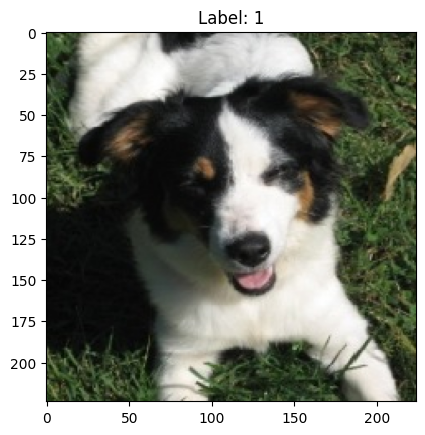

Image: (224, 224, 3)
Label: 0


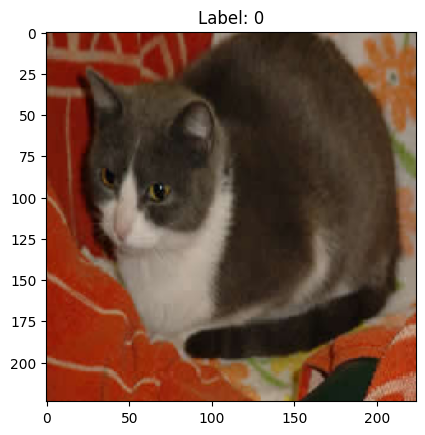

Image: (224, 224, 3)
Label: 1


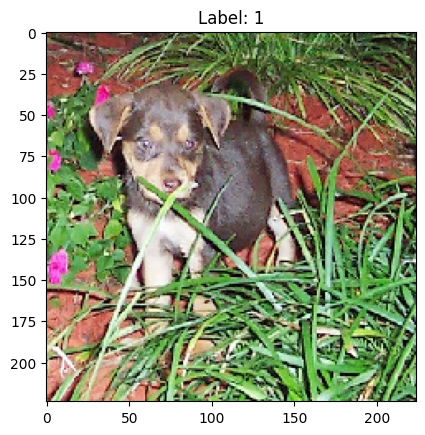

Image: (224, 224, 3)
Label: 1


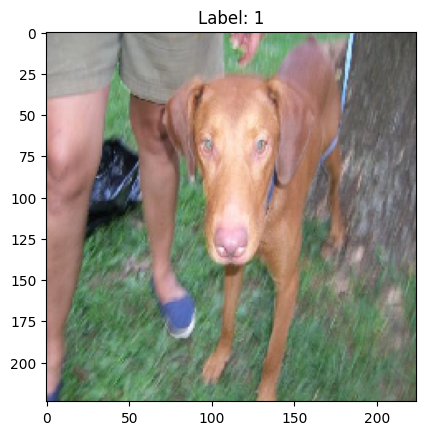

Image: (224, 224, 3)
Label: 0


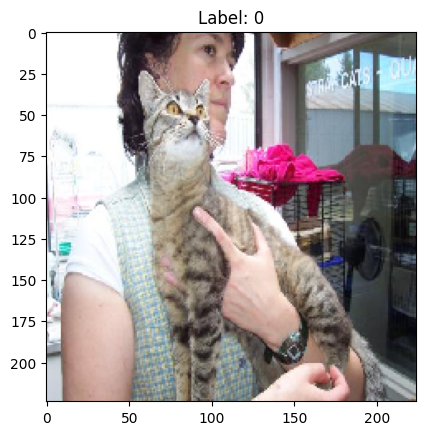

In [3]:
count = 0
for example in dataset.as_numpy_iterator():
    image = example['image']
    label = example['label']
    print(f"Image: {image.shape}")
    print(f"Label: {label}")

    # Display the image
    plt.imshow(image)
    plt.title(f"Label: {label}")
    plt.show()

    count += 1
    if count == 5:
        break

# Dataset Preprocessing

**Loading a sample image from directory:**

In [4]:
image_path = r"C:\Users\taies\TEST\PetImages\Cat\3.jpg"
def load_sample(image_path, label):
    # loading the file into PIL Image
    image = Image.open(image_path)
    # Converting PIL Image to numpy array
    image = np.array(image)
    # Normalising pixel values to be between 0 and 1
    image = image / 255.0
    return image, label

**Visualising sample image to test augmentation steps:**

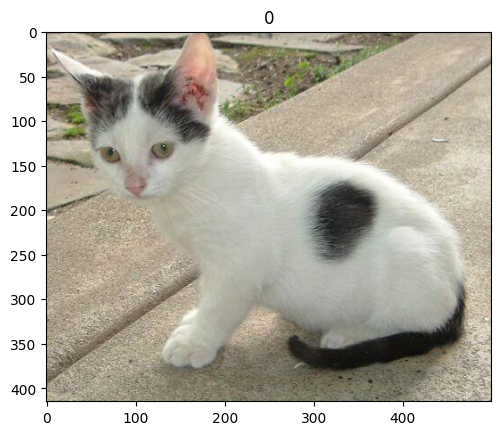

In [5]:
image, label = load_sample('./PetImages/Cat/3.jpg', 0)
fig, ax = plt.subplots()
ax.imshow(image)
ax.set_title(label)
plt.show()

**Adding image size argument needed for imge to be processed:**

In [6]:
def resize_pil(image_path, size=(224, 224)):
    # Open the image
    image = Image.open(image_path)

    # Converting to grayscale if it's a color image
    if image.mode != 'L':
        image = image.convert('L')

    # Resizing the image
    image = image.resize(size)

    # Converting the Pillow image back to a NumPy array
    image = np.array(image, dtype=np.float32)

    # Normalising the pixel values to [0, 1]
    image /= 255.0

    return image


**Implementing random crop.  This allows crops from the center point based on the fraction (sizing depending on input image height and width):**

In [7]:
def random_crop_pil(image_path, size=(224, 224)):
    image = Image.open(image_path)

    max_left = max(image.width - size[0], 0)
    max_top = max(image.height - size[1], 0)

    left = np.random.randint(0, max_left + 1)
    top = np.random.randint(0, max_top + 1)
    right = left + size[0]
    bottom = top + size[1]

    print(f"max_left: {max_left}, max_top: {max_top}")
    print(f"left: {left}, top: {top}, right: {right}, bottom: {bottom}")


    image = image.crop((left, top, right, bottom))
    return image


**Visualising random crop applied to image:**

max_left: 276, max_top: 191
left: 208, top: 0, right: 432, bottom: 224


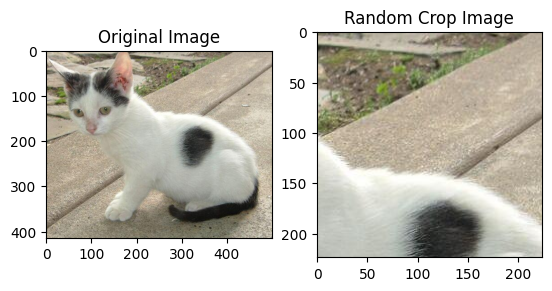

In [8]:
image, label = load_sample('./PetImages/Cat/3.jpg', 0)

fig, ax = plt.subplots(1, 2)

ax[0].imshow(image)
ax[0].set_title("Original Image")

image_pil_cropped = random_crop_pil('./PetImages/Cat/3.jpg')
ax[1].imshow(image_pil_cropped)
ax[1].set_title("Random Crop Image")

plt.show()

**Implementing central crop. Random crop may crop the uneccessarry sections of  an image that cannot classify correctly, so random central crop also used:**

In [9]:
def central_crop_pil(image_path, size=(224, 224), central_fraction=0.84):
    image = Image.open(image_path)
    
    # Calculation of crop region
    center_x = image.width // 2
    center_y = image.height // 2
    crop_width = int(image.width * central_fraction)
    crop_height = int(image.height * central_fraction)
    
    left = max(0, center_x - crop_width // 2)
    top = max(0, center_y - crop_height // 2)
    right = min(image.width, left + crop_width)
    bottom = min(image.height, top + crop_height)
    
    image = image.crop((left, top, right, bottom))
    image = image.resize(size, Image.LANCZOS)
    
    return image

**Visualising central crop applied to image:**

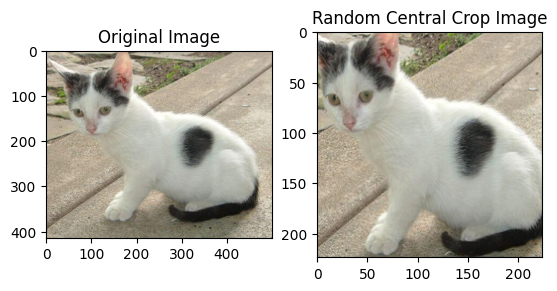

In [10]:
#image, label = load_sample('./PetImages/Cat/3.jpg', 0)
fig, ax = plt.subplots(1, 2)

ax[0].imshow(image)
ax[0].set_title("Original Image")

image_pil_cropped = central_crop_pil('./PetImages/Cat/3.jpg')
ax[1].imshow(image_pil_cropped)
ax[1].set_title("Random Central Crop Image")

plt.show()

**Implementing random brightness:**

In [11]:
def random_brightness_pil(image_path, max_delta=0.5):
    image = Image.open(image_path)
    enhancer = ImageEnhance.Brightness(image)
    image = enhancer.enhance(1 + np.random.uniform(-max_delta, max_delta))
    return image

**Visualising random brightness applied to image:**

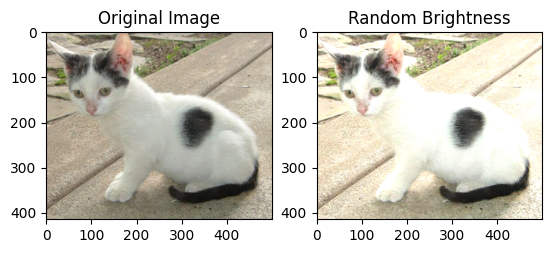

In [12]:
image, label = load_sample('./PetImages/Cat/3.jpg', 0)

fig, ax = plt.subplots(1, 2)

ax[0].imshow(image)
ax[0].set_title("Original Image")

image_pil_cropped = random_brightness_pil('./PetImages/Cat/3.jpg')
ax[1].imshow(image_pil_cropped)
ax[1].set_title("Random Brightness")

plt.show()

**Implementing random contrast:**

In [13]:
def random_contrast_pil(image_path, lower=0.5, upper=1.5):
    image = Image.open(image_path)
    enhancer = ImageEnhance.Contrast(image)
    image = enhancer.enhance(np.random.uniform(lower, upper))
    return image

**Visualising random contrast applied to image:**

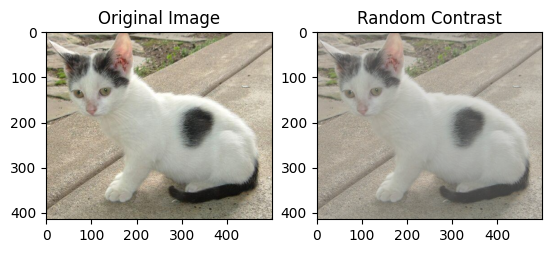

In [14]:
image, label = load_sample('./PetImages/Cat/3.jpg', 0)

fig, ax = plt.subplots(1, 2)

ax[0].imshow(image)
ax[0].set_title("Original Image")

image_pil_cropped = random_contrast_pil('./PetImages/Cat/3.jpg')
ax[1].imshow(image_pil_cropped)
ax[1].set_title("Random Contrast")

plt.show()

**Merging defined data augmentation in one function and adding mirroring augmentation:**

In [15]:
def random_jitter_pil(image_path):
    # Resizing image to 224 x 224
    image = resize_pil(image_path)
    # Random Cropping
    image = random_crop_pil(image_path)
    # Random contrast
    image = random_contrast_pil(image_path)
    # Random brightness
    image = random_brightness_pil(image_path)
    # Random mirroring
    if np.random.rand() < 0.5:
        image = np.fliplr(image)
  
    return image



**Visualising random jitter applied to image with other augmentations:**

max_left: 276, max_top: 191
left: 72, top: 88, right: 296, bottom: 312


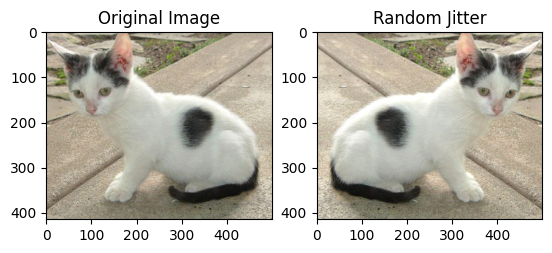

In [16]:
image, label = load_sample('./PetImages/Cat/3.jpg', 0)
fig, ax = plt.subplots(1, 2)
ax[0].imshow(image)
ax[0].set_title("Original Image")
image_pil_cropped = random_jitter_pil('./PetImages/Cat/3.jpg')
ax[1].imshow(image_pil_cropped)
ax[1].set_title("Random Jitter")

plt.show()

**Defining dataset for Augmentation techniques to be applied:**

In [17]:
# Load the dataset
data_generator = ImageDataGenerator(rescale=1./255,
    validation_split=0.2)

data = data_generator.flow_from_directory(
    'C:/Users/taies/TEST/PetImages',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# Lists to store batches
images_list = []
labels_list = []

# Iterate through the batches
for i in range(5):  
    # Loading batch from the generator
    batch = data.next()

    images, labels = batch

    # Converting to NumPy arrays
    images_np = np.array(images)

    # Set label to 1 for one class and 0 for the other
    labels_np = np.argmax(labels, axis=1)
    
    # Appending to lists
    images_list.append(images_np)
    labels_list.append(labels_np)

# Concatenate lists into NumPy arrays
images_dataset = np.concatenate(images_list, axis=0)
labels_dataset = np.concatenate(labels_list, axis=0)



Found 24972 images belonging to 2 classes.


**Train, Test split:**

In [18]:
# Split the data into training and validation sets
train_images, val_images, train_labels, val_labels = train_test_split(
    images_dataset, labels_dataset, test_size=0.2, random_state=42
)

# TensorFlow dataset from the NumPy arrays
train_dataset = tf.data.Dataset.from_tensor_slices({'image': train_images, 'label': train_labels})
val_dataset = tf.data.Dataset.from_tensor_slices({'image': val_images, 'label': val_labels})

In [19]:
train_images, train_labels = [], []
for example in tf.as_numpy(dataset):
    train_images.append(example['image'])
    train_labels.append(example['label'])

train_images = np.array(train_images)
train_labels = np.array(train_labels)

**Preview 5 images of dataset now being worked with:**

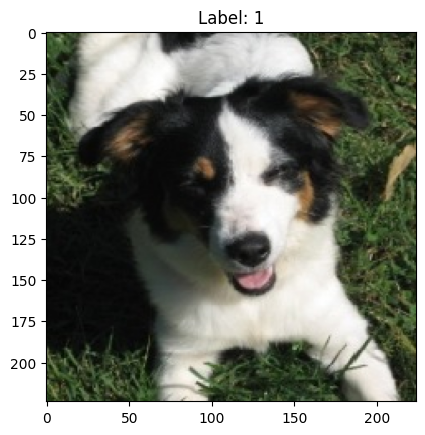

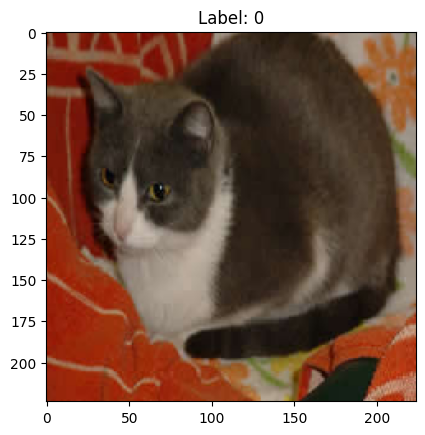

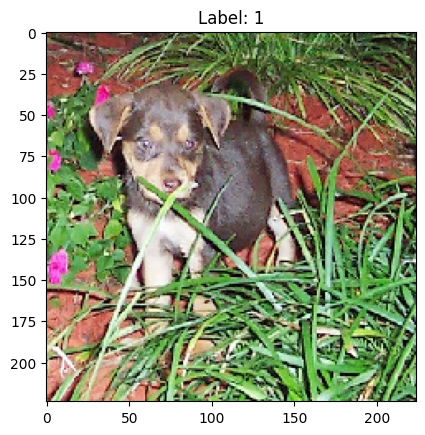

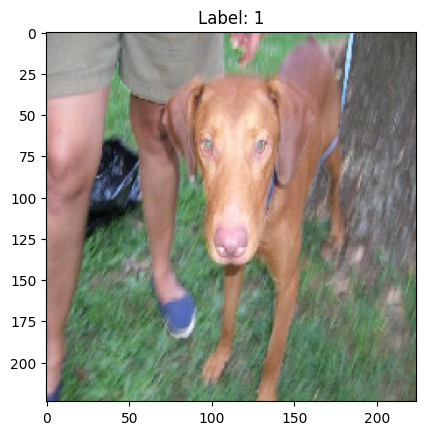

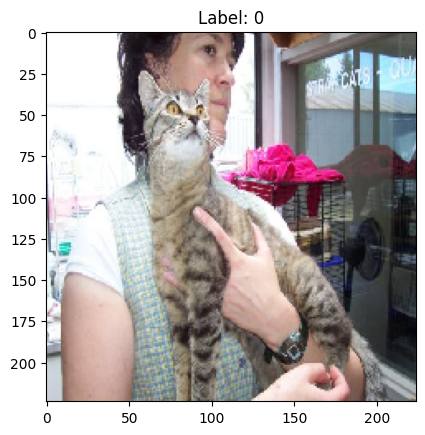

In [20]:
# Define the number of images to display
num_images = 5

for i in range(num_images):
    image = train_images[i]
    label = train_labels[i]

    # Assuming 'image' is the NumPy array representing the image
    image = (image * 255).astype(np.uint8)

    # If the image has shape (1, 1, 3), squeeze it to (3,) assuming it's a valid image
    image = np.squeeze(image)

    # Convert the image from NumPy array to PIL Image
    image = Image.fromarray(image)


    # Display the image and label
    plt.imshow(image)
    plt.title(f"Label: {label}")
    plt.show()


**Overall pre-processing function (Augmentation):**

In [21]:
def preprocess_image(image, label):
    
    # Converting to uint8 and reshaping
    image = (image * 255).astype(np.uint8)
    image = np.squeeze(image)

    # Converting TensorFlow tensor to NumPy array
    image = np.array(image)

    # Decoding image using TensorFlow
    image = tf.image.decode_image(tf.io.encode_jpeg(image).numpy(), channels=3)

    # Convert to PIL Image
    image = Image.fromarray(np.array(image))

    # Randomly apply central crop
    image = tf.image.random_crop(image, size=(224, 224, 3))
    # Randomly adding contrast
    image = tf.image.random_contrast(image, lower=0.5, upper=1.5)
    # Randomly adding brightness
    image = tf.image.random_brightness(image, max_delta=0.5)
    # Randomly adding mirroring
    image = tf.image.random_flip_left_right(image)
    # Randomly add rotation
    angles = np.random.randint(0, 3, 1)
    image = tf.image.rot90(image, k=angles[0])

    # Resizing image using tf.image.resize
    image = tf.image.resize(image, (224, 224), method=tf.image.ResizeMethod.BICUBIC) #used BICBIC for higher quality resizing

    # Converting the image back to a NumPy array
    image = np.array(image)

    # Converting the image to float32 and normalize pixel values
    image = image.astype(np.float32) / 255.0

    return image, label


In [22]:
# Preprocess the first x number images
preprocessed_images = []
preprocessed_labels = []

for i in range(100):
    image = train_images[i]
    label = train_labels[i]

    preprocessed_image, preprocessed_label = preprocess_image(image, label)
    preprocessed_images.append(preprocessed_image)
    preprocessed_labels.append(preprocessed_label)

**Visualising preview of preprocessed images (Augmentation techniques applied):**

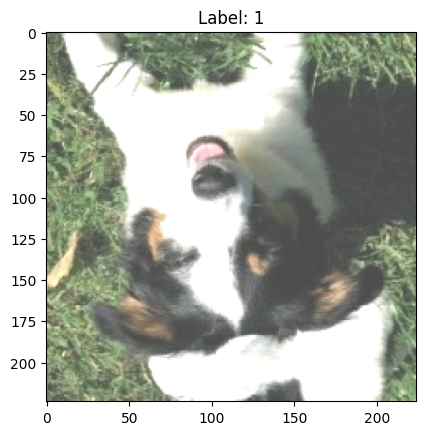

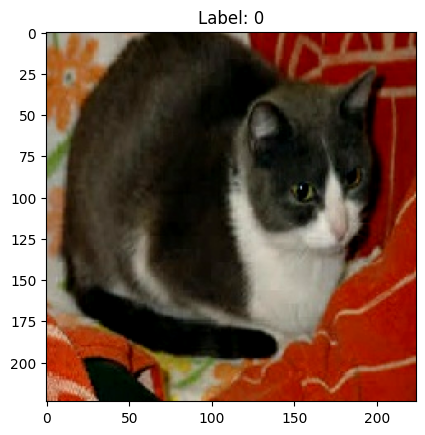

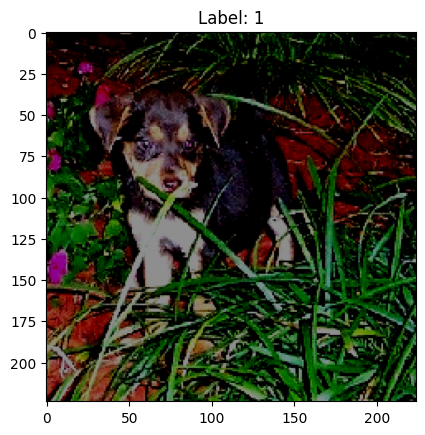

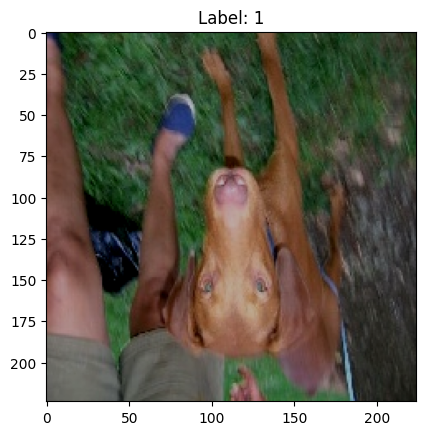

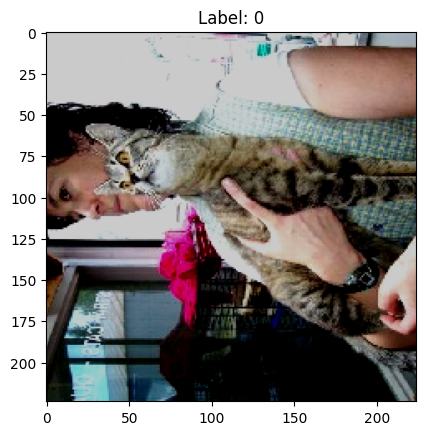

In [23]:
# Display the preprocessed images with labels
for i in range(5):
    image = preprocessed_images[i]
    label = preprocessed_labels[i]

    plt.imshow(image)
    plt.title(f"Label: {label}")
    plt.show()

# Modelling

 In this code, we define a simple CNN model with several convolutional layers followed by max-pooling layers, and then fully connected layers for classification. The final layer uses sigmoid activation since it's a binary classification task.

**CNN model with augmentation applied:**

In [24]:
def create_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')  # Binary classification
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = create_model()

# Convert preprocessed images to a NumPy array
preprocessed_images = np.array(preprocessed_images)

# Convert preprocessed labels to a NumPy array
preprocessed_labels = np.array(preprocessed_labels)

# Train the model
history = model.fit(preprocessed_images, preprocessed_labels, epochs=10)

# Evaluate the model
loss, accuracy = model.evaluate(preprocessed_images, preprocessed_labels)
print("Loss:", loss)
print("Accuracy:", accuracy)





Epoch 1/10


4/4 [==============================] - 4s 503ms/step - loss: 4.7740 - accuracy: 0.5000
Epoch 2/10
4/4 [==============================] - 2s 507ms/step - loss: 3.8912 - accuracy: 0.5600
Epoch 3/10
4/4 [==============================] - 2s 447ms/step - loss: 1.9712 - accuracy: 0.4700
Epoch 4/10
4/4 [==============================] - 2s 447ms/step - loss: 0.6442 - accuracy: 0.6600
Epoch 5/10
4/4 [==============================] - 2s 436ms/step - loss: 0.5714 - accuracy: 0.7000
Epoch 6/10
4/4 [==============================] - 2s 445ms/step - loss: 0.3939 - accuracy: 0.8100
Epoch 7/10
4/4 [==============================] - 2s 433ms/step - loss: 0.4488 - accuracy: 0.7500
Epoch 8/10
4/4 [==============================] - 2s 439ms/step - loss: 0.2393 - accuracy: 0.9200
Epoch 9/10
4/4 [==============================] - 2s 437ms/step - loss: 0.2249 - accuracy: 0.8900
Epoch 10/10
4/4 [==============================] - 1s 107ms/step - loss: 0.1211 - accuracy: 0.9800
Loss: 0.121109

**Modelling without augmentation applied to raw dataset to compare accuracy against augmented dataset**

In [25]:
# Load the dataset with generator instance
data_generator = ImageDataGenerator(rescale=1./255,
    validation_split=0.2)

train_dataset= data_generator.flow_from_directory(
    'C:/Users/taies/TEST/PetImages',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

validation_dataset = data_generator.flow_from_directory(
    'C:/Users/taies/TEST/PetImages',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)


Found 19979 images belonging to 2 classes.
Found 4993 images belonging to 2 classes.


**CNN model without augmentation applied:**

In [26]:
def create_model():
    model = models.Sequential([
        # Convolutional layers
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        # Flatten the output and add fully connected layers
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dense(1, activation='sigmoid')  # Binary classification, so use sigmoid activation
    ])

    # Compile the model
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

# Create an instance of the model
model = create_model()

# Train the model with the specified steps_per_epoch
history = model.fit(train_dataset, epochs=10)  

Epoch 1/10
389/625 [=================>............] - ETA: 4:08 - loss: 0.6913 - accuracy: 0.5572

c:\Users\taies\AppData\Local\Programs\Python\Python311\Lib\site-packages\PIL\TiffImagePlugin.py:866: UserWarning: Truncated File Read
  warnings.warn(str(msg))


625/625 [==============================] - 657s 1s/step - loss: 0.6659 - accuracy: 0.5906
Epoch 2/10
625/625 [==============================] - 467s 747ms/step - loss: 0.5212 - accuracy: 0.7428
Epoch 3/10
625/625 [==============================] - 444s 710ms/step - loss: 0.4280 - accuracy: 0.8013
Epoch 4/10
625/625 [==============================] - 391s 625ms/step - loss: 0.3492 - accuracy: 0.8474
Epoch 5/10
625/625 [==============================] - 379s 607ms/step - loss: 0.2823 - accuracy: 0.8788
Epoch 6/10
625/625 [==============================] - 441s 705ms/step - loss: 0.2028 - accuracy: 0.9164
Epoch 7/10
625/625 [==============================] - 389s 623ms/step - loss: 0.1291 - accuracy: 0.9485
Epoch 8/10
625/625 [==============================] - 391s 625ms/step - loss: 0.0768 - accuracy: 0.9712
Epoch 9/10
625/625 [==============================] - 419s 670ms/step - loss: 0.0488 - accuracy: 0.9828
Epoch 10/10
625/625 [==============================] - 428s 685ms/step - loss:

In [35]:
# Model evaluation
loss, accuracy = model.evaluate(train_dataset)
print("Loss:", loss)
print("Accuracy:", accuracy)

609/625 [============================>.] - ETA: 4s - loss: 0.3422 - accuracy: 0.8807

c:\Users\taies\AppData\Local\Programs\Python\Python311\Lib\site-packages\PIL\TiffImagePlugin.py:866: UserWarning: Truncated File Read
  warnings.warn(str(msg))


625/625 [==============================] - 191s 304ms/step - loss: 0.3433 - accuracy: 0.8807
Loss: 0.34329846501350403
Accuracy: 0.8806747198104858


# Model Evaluation

**Comparison of Model Accuracy and Loss with and without Augmentation over 10 Epochs:**

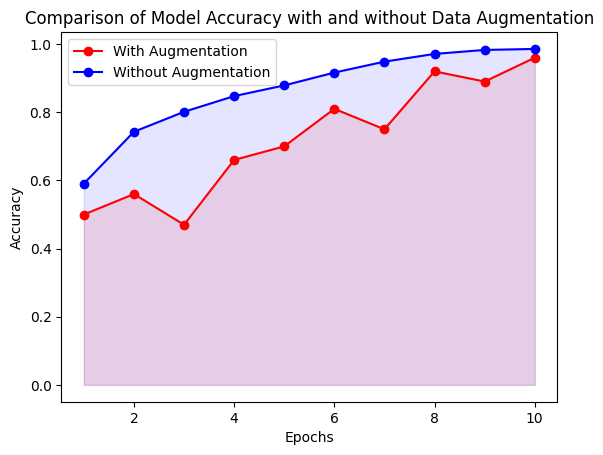

In [28]:
# Accuracy values for both models
accuracy_with_augmentation = [0.5000, 0.5600, 0.4700, 0.6600, 0.7000, 0.8100, 0.7500, 0.9200, 0.8900, 0.9600]
accuracy_without_augmentation = [0.5906, 0.7428, 0.8013, 0.8474, 0.8788, 0.9164, 0.9485, 0.9712, 0.9828, 0.9858]

epochs = range(1, 11)

# Plot of accuracy comparison
plt.plot(epochs, accuracy_with_augmentation, marker='o', linestyle='-', color='red', label='With Augmentation')
plt.plot(epochs, accuracy_without_augmentation, marker='o', linestyle='-', color='blue', label='Without Augmentation')

plt.fill_between(epochs, accuracy_with_augmentation, color='red', alpha=0.1)  # Adding filled area for model with augmentation
plt.fill_between(epochs, accuracy_without_augmentation, color='blue', alpha=0.1)  # Adding filled area for model without augmentation

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Comparison of Model Accuracy with and without Data Augmentation')
plt.legend()

plt.show()


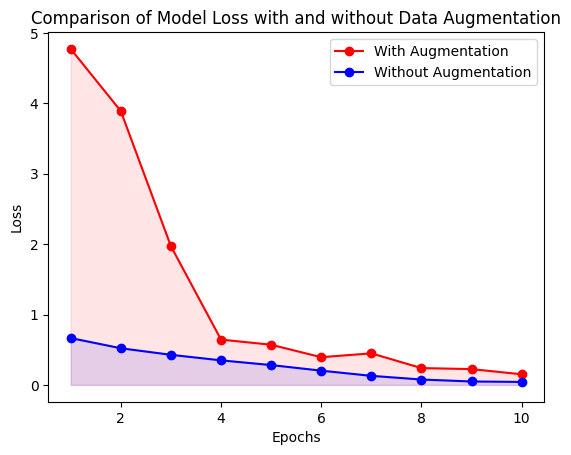

In [30]:
# Loss values for both models
loss_with_augmentation = [4.7740, 3.8912, 1.9712, 0.6442, 0.5714, 0.3939, 0.4488, 0.2393, 0.2249, 0.1511]
loss_without_augmentation = [0.6659, 0.5212, 0.4280, 0.3492, 0.2823, 0.2028, 0.1291, 0.0768, 0.0488, 0.0427]

epochs = range(1, 11)

# Plot of loss comparison
plt.plot(epochs, loss_with_augmentation, marker='o', linestyle='-', color='red', label='With Augmentation')
plt.plot(epochs, loss_without_augmentation, marker='o', linestyle='-', color='blue', label='Without Augmentation')

plt.fill_between(epochs, loss_with_augmentation, color='red', alpha=0.1)  # Adding filled area for model with augmentation
plt.fill_between(epochs, loss_without_augmentation, color='blue', alpha=0.1)  # Adding filled area for model without augmentation

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Comparison of Model Loss with and without Data Augmentation')
plt.legend()

plt.show()

**Overall Comparison of Model Acccuracy and Loss with and without Augmentation over 10 Epochs (with validaion):**

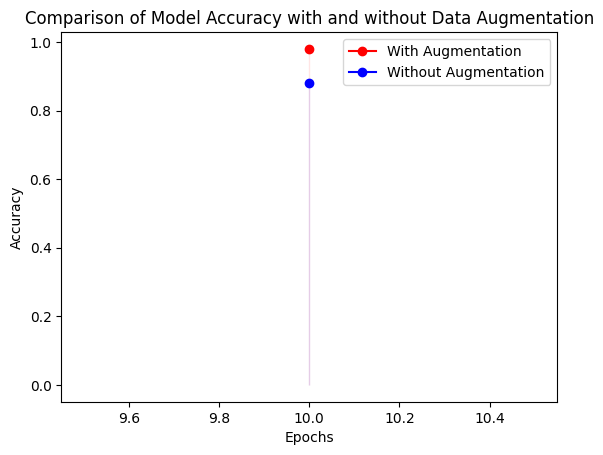

In [6]:
# Final Accuracy values for both models
accuracy_with_augmentation = [0.9800000190734863]
accuracy_without_augmentation = [0.8806747198104858]

epochs = epochs = range(10, len(accuracy_with_augmentation) + 10)

# Plot the accuracy comparison
plt.plot(epochs, accuracy_with_augmentation, marker='o', linestyle='-', color='red', label='With Augmentation')
plt.plot(epochs, accuracy_without_augmentation, marker='o', linestyle='-', color='blue', label='Without Augmentation')

plt.fill_between(epochs, accuracy_with_augmentation, color='red', alpha=0.1)  # Line fill
plt.fill_between(epochs, accuracy_without_augmentation, color='blue', alpha=0.1)  # Line fill

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Comparison of Model Accuracy with and without Data Augmentation')
plt.legend()

plt.show()

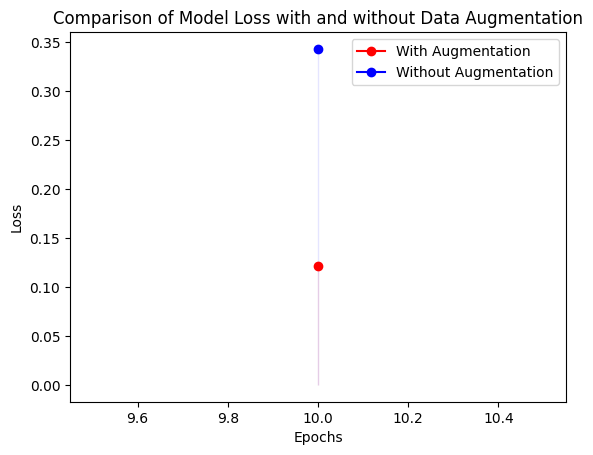

In [5]:
#Final Loss values for both models
loss_with_augmentation = [0.12110957503318787]
loss_without_augmentation = [0.34329846501350403]

epochs = range(10, len(accuracy_with_augmentation) + 10)

# Plot of loss comparison
plt.plot(epochs, loss_with_augmentation, marker='o', linestyle='-', color='red', label='With Augmentation')
plt.plot(epochs, loss_without_augmentation, marker='o', linestyle='-', color='blue', label='Without Augmentation')

plt.fill_between(epochs, loss_with_augmentation, color='red', alpha=0.1)  # Line fill
plt.fill_between(epochs, loss_without_augmentation, color='blue', alpha=0.1)  # Line fill

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Comparison of Model Loss with and without Data Augmentation')
plt.legend()

plt.show()

**Other Workings..**

**Checking for corrupted files, any files that were corrupted removed from dataset in local directory:**

In [ ]:
def check_images_in_subdirectory(directory_path):
    for root, _, files in os.walk(directory_path):
        for filename in files:
            image_path = os.path.join(root, filename)
            if image_path.endswith((".jpg", ".jpeg", ".png", ".gif")):
                check_image(image_path)

def check_image(image_path):
    image_format = imghdr.what(image_path)
    if image_format is None:
        print(f"Image {image_path} is corrupted")
    else:
        print(f"Image {image_path} is valid ({image_format} format)")

directory_path = r"C:\Users\taies\TEST\PetImages"
check_images_in_subdirectory(directory_path)

Image C:\Users\taies\TEST\PetImages\Cat\0.jpg is valid (jpeg format)
Image C:\Users\taies\TEST\PetImages\Cat\1.jpg is valid (jpeg format)
Image C:\Users\taies\TEST\PetImages\Cat\10.jpg is valid (jpeg format)


C:\Users\taies\AppData\Local\Temp\ipykernel_27764\1153001025.py:2: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


Image C:\Users\taies\TEST\PetImages\Cat\100.jpg is valid (jpeg format)
Image C:\Users\taies\TEST\PetImages\Cat\1000.jpg is valid (jpeg format)
Image C:\Users\taies\TEST\PetImages\Cat\10000.jpg is valid (jpeg format)
Image C:\Users\taies\TEST\PetImages\Cat\10001.jpg is valid (jpeg format)
Image C:\Users\taies\TEST\PetImages\Cat\10002.jpg is valid (jpeg format)
Image C:\Users\taies\TEST\PetImages\Cat\10003.jpg is valid (jpeg format)
Image C:\Users\taies\TEST\PetImages\Cat\10004.jpg is valid (jpeg format)
Image C:\Users\taies\TEST\PetImages\Cat\10005.jpg is valid (jpeg format)
Image C:\Users\taies\TEST\PetImages\Cat\10006.jpg is valid (jpeg format)
Image C:\Users\taies\TEST\PetImages\Cat\10007.jpg is valid (jpeg format)
Image C:\Users\taies\TEST\PetImages\Cat\10008.jpg is valid (jpeg format)
Image C:\Users\taies\TEST\PetImages\Cat\10009.jpg is valid (jpeg format)
Image C:\Users\taies\TEST\PetImages\Cat\1001.jpg is valid (jpeg format)
Image C:\Users\taies\TEST\PetImages\Cat\10010.jpg is va

# Conclusion

For the CNN model run without any augmentation, the model achieved a final accuracy of 88.07% after 10 epochs. The loss decreased steadily over the epochs, reaching 0.3433 in the final epoch. This indicated that model without augmentation performed well, showing a steady improvement in accuracy and reduction in loss. The accuracy suggests that the model learnt the patterns in the training data effectively however, loss - epoch graph shows that the accuracy/loss plateaued fairly quicker than the augmented model (8 epochs) suggesting limited learning afterwards.

For the CNN Model run with augment applied, the model with augmentation outperformed the model without augmentation by a large margin, achieving a higher final accuracy of 0.98 (98%). This indicated that the model generalises well and responds well to unseen data with augmentation. Augmentation helps the model generalize better by exposing it to a variety of augmented images during training, leading to improved performance on unseen data. The model without augmentation, although good, might be more prone to overfitting as evidenced by the lower accuracy compared to the model with augmentation. Augmentation is a powerful technique that enhances the model's ability to generalize and perform well on new, unseen data. Whilst data augmentation is generally beneficial for training robust models, there are scenarios where certain augmentation techniques might not improve or could potentially decrease model accuracy. On the other hand, augmentations simulate real-world conditions to help the model be more adaptable for challenges it may face